In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import statistics

In [2]:
df = pd.read_csv('var3.csv')

In [3]:
df.describe()

,Unnamed: 0,X,y
count,200.000000,2.000000e+02,200.000000
mean,99.500000,1.421085e-16,0.312396
std,57.879185,2.326801e+00,31.846644
min,0.000000,-4.000000e+00,-93.957604
25%,49.750000,-2.000000e+00,-8.162983
50%,99.500000,-2.498002e-16,-0.062606
75%,149.250000,2.000000e+00,10.204757
max,199.000000,4.000000e+00,112.966234


<Axes: >

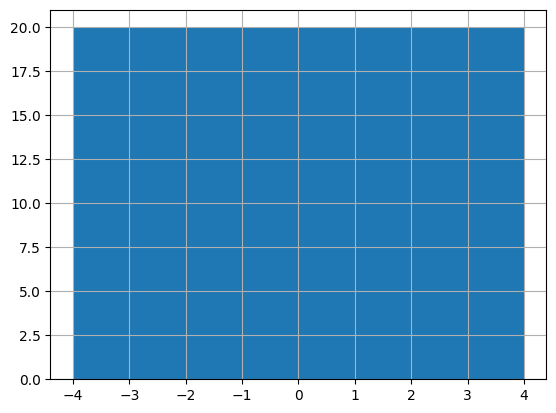

In [4]:
df['X'].hist() # Равномерное распределение (униформное)

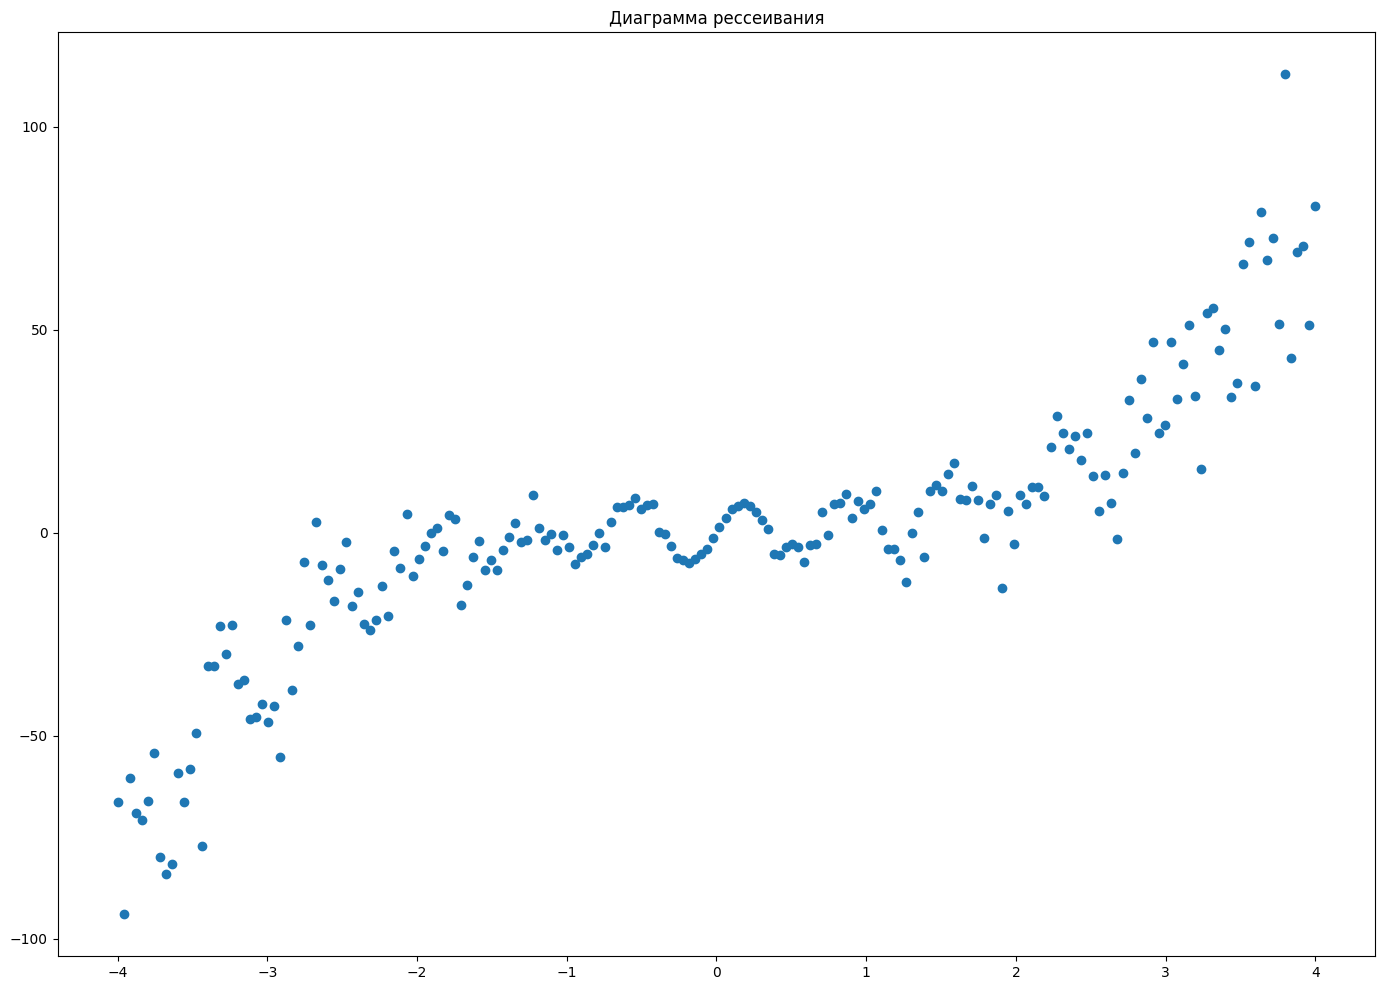

In [5]:
plt.figure(figsize=(17, 12))
plt.scatter(df['X'], df['y'])
plt.title('Диаграмма рессеивания')
plt.show()

In [6]:
# Попробуем разделить данные на 3 части в зависимости от плотности данных:

# 1 участок [-4; -1.25)

# 2 участок [-1.25; 1.25]

# 3 участок (1.25; 4]

df_1 = df[df['X'] < -1.25]
df_2 = df[(df['X'] >= -1.25) & (df['X'] <= 1.25)]
df_3 = df[df['X'] > 1.25]

X_1, y_1 = torch.tensor(df_1['X'].values.reshape(-1, 1), dtype=torch.float32), torch.tensor(df_1['y'].values.reshape(-1, 1), dtype=torch.float32)
X_2, y_2 = torch.tensor(df_2['X'].values.reshape(-1, 1), dtype=torch.float32), torch.tensor(df_2['y'].values.reshape(-1, 1), dtype=torch.float32)
X_3, y_3 = torch.tensor(df_3['X'].values.reshape(-1, 1), dtype=torch.float32), torch.tensor(df_3['y'].values.reshape(-1, 1), dtype=torch.float32)

X, y = torch.tensor(df['X'].values.reshape(-1, 1), dtype=torch.float32), torch.tensor(df['y'].values.reshape(-1, 1), dtype=torch.float32)

In [31]:
# Определение байесовского линейного слоя
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        
        self.weight_mu = nn.Parameter(torch.randn(out_features, in_features) * 0.1) # Для rho инициализация нулями более логична, так как при экспоненциальном преобразовании это даст начальное стандартное отклонение ~1.0; умножение на 0.1 сохраняет малый масштаб начальных значений
        self.weight_rho = nn.Parameter(torch.zeros(out_features, in_features))

        self.bias_mu = nn.Parameter(torch.randn(out_features) * 0.1)
        self.bias_rho = nn.Parameter(torch.zeros(out_features))

    def forward(self, x, sample=True):
        if sample:
            weight = self.weight_mu + torch.log1p(torch.exp(self.weight_rho)) * torch.randn_like(self.weight_rho)
            bias = self.bias_mu + torch.log1p(torch.exp(self.bias_rho)) * torch.randn_like(self.bias_rho)
        else:
            weight, bias = self.weight_mu, self.bias_mu
        return F.linear(x, weight, bias)

    def kl_divergence(self): # Упрощенный расчет KL без явного prior_sigma
        return 0.5 * (torch.sum(torch.log1p(torch.exp(self.weight_rho))**2 + torch.sum(torch.log1p(torch.exp(self.bias_rho))**2)))

# Определение байесовского нелинейного слоя
class BayesianNonlinear(nn.Module):
    def __init__(self, in_features, out_features, activation='sigmoid'):
        super().__init__()
        self.linear = BayesianLinear(in_features, out_features)
        self.activation = activation

    def forward(self, x, sample=True):
        x = self.linear(x, sample)
        if self.activation == 'relu':
            return F.relu(x)
        elif self.activation == 'tanh':
            return torch.tanh(x)
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)

        return x  # Линейная активация

    def kl_divergence(self):
        return self.linear.kl_divergence()
    
class BNN_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = BayesianLinear(1, 50)
        self.layer2 = BayesianLinear(50, 50)
        self.layer3 = BayesianLinear(50, 1)
    
    def forward(self, x, sample=True):
        x = torch.relu(self.layer1(x, sample))
        x = torch.tanh(self.layer2(x, sample))
        return self.layer3(x, sample)
    
    def kl_loss(self):
        return self.layer1.kl_divergence() + self.layer2.kl_divergence() + self.layer3.kl_divergence()
 
class BNN_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = BayesianLinear(1, 20)
        self.layer2 = BayesianLinear(20, 1)
    
    def forward(self, x, sample=True):
        x = F.sigmoid(self.layer1(x, sample))
        x = self.layer2(x, sample)
 
        return x
    
    def kl_loss(self):
        return self.layer1.kl_divergence() + self.layer2.kl_divergence()

class BNN_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = BayesianLinear(1, 50)
        self.layer2 = BayesianLinear(50, 50)
        self.layer3 = BayesianLinear(50, 1)
    
    def forward(self, x, sample=True):
        x = torch.relu(self.layer1(x, sample))
        x = torch.tanh(self.layer2(x, sample))
        return self.layer3(x, sample)
    
    def kl_loss(self):
        return self.layer1.kl_divergence() + self.layer2.kl_divergence() + self.layer3.kl_divergence()

In [8]:
n_epochs = 50000

def train_model(model, optimizer, X, y):
    model.train()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        preds = model(X)
        mse_loss = F.mse_loss(preds, y)
        kl_loss = model.kl_loss()
        total_loss = mse_loss + kl_loss / len(X)
        total_loss.backward()
        optimizer.step()
        
        if epoch % 300 == 0:
            print(f'Epoch {epoch}: MSE Loss = {mse_loss.item():.3f}, KL Loss = {kl_loss.item():.3f}')

        if mse_loss <= 14 and kl_loss <= 500:
            print(f"Остановка: MSE={mse_loss:.2f}, KL={kl_loss:.2f}")
            break
            
    return mse_loss.item(), kl_loss.item()

In [9]:
model1 = BNN_1()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)
mse1, kl1 = train_model(model1, optimizer1, X_1, y_1)

Epoch 0: MSE Loss = 1591.902, KL Loss = 31265.482
Epoch 300: MSE Loss = 824.311, KL Loss = 3713.433
Epoch 600: MSE Loss = 694.023, KL Loss = 1974.283
Epoch 900: MSE Loss = 698.339, KL Loss = 1446.888
Epoch 1200: MSE Loss = 531.476, KL Loss = 1158.385
Epoch 1500: MSE Loss = 591.302, KL Loss = 963.446
Epoch 1800: MSE Loss = 292.547, KL Loss = 853.367
Epoch 2100: MSE Loss = 211.311, KL Loss = 773.972
Epoch 2400: MSE Loss = 138.894, KL Loss = 719.065
Epoch 2700: MSE Loss = 141.932, KL Loss = 676.502
Epoch 3000: MSE Loss = 126.984, KL Loss = 639.214
Epoch 3300: MSE Loss = 120.592, KL Loss = 607.187
Epoch 3600: MSE Loss = 126.409, KL Loss = 578.079
Epoch 3900: MSE Loss = 115.483, KL Loss = 550.618
Epoch 4200: MSE Loss = 103.996, KL Loss = 525.178
Epoch 4500: MSE Loss = 105.761, KL Loss = 500.335
Epoch 4800: MSE Loss = 100.205, KL Loss = 475.565
Epoch 5100: MSE Loss = 92.000, KL Loss = 451.536
Epoch 5400: MSE Loss = 92.224, KL Loss = 427.635
Epoch 5700: MSE Loss = 86.039, KL Loss = 403.347
Ep

In [10]:
model2 = BNN_2() 
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01) 
mse2, kl2 = train_model(model2, optimizer2, X_2, y_2)

Epoch 0: MSE Loss = 28.526, KL Loss = 110.504
Epoch 300: MSE Loss = 28.037, KL Loss = 26.006
Epoch 600: MSE Loss = 29.198, KL Loss = 11.644
Epoch 900: MSE Loss = 27.803, KL Loss = 6.738
Epoch 1200: MSE Loss = 27.850, KL Loss = 4.463
Epoch 1500: MSE Loss = 27.763, KL Loss = 3.162
Epoch 1800: MSE Loss = 28.004, KL Loss = 2.365
Epoch 2100: MSE Loss = 27.729, KL Loss = 1.821
Epoch 2400: MSE Loss = 27.645, KL Loss = 1.447
Epoch 2700: MSE Loss = 27.285, KL Loss = 1.165
Epoch 3000: MSE Loss = 26.602, KL Loss = 0.940
Epoch 3300: MSE Loss = 25.435, KL Loss = 0.762
Epoch 3600: MSE Loss = 23.736, KL Loss = 0.627
Epoch 3900: MSE Loss = 22.368, KL Loss = 0.519
Epoch 4200: MSE Loss = 21.046, KL Loss = 0.430
Epoch 4500: MSE Loss = 19.833, KL Loss = 0.356
Epoch 4800: MSE Loss = 18.303, KL Loss = 0.287
Epoch 5100: MSE Loss = 16.653, KL Loss = 0.243
Epoch 5400: MSE Loss = 15.058, KL Loss = 0.194
Остановка: MSE=13.99, KL=0.18


In [32]:
model3 = BNN_3()
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.01)
mse3, kl3 = train_model(model3, optimizer3, X_3, y_3)

Epoch 0: MSE Loss = 1270.738, KL Loss = 31265.482
Epoch 300: MSE Loss = 676.631, KL Loss = 3640.629
Epoch 600: MSE Loss = 638.714, KL Loss = 1972.607
Epoch 900: MSE Loss = 642.874, KL Loss = 1484.900
Epoch 1200: MSE Loss = 371.400, KL Loss = 1206.734
Epoch 1500: MSE Loss = 265.807, KL Loss = 1008.883
Epoch 1800: MSE Loss = 229.823, KL Loss = 888.840
Epoch 2100: MSE Loss = 223.289, KL Loss = 796.611
Epoch 2400: MSE Loss = 220.710, KL Loss = 733.328
Epoch 2700: MSE Loss = 171.304, KL Loss = 685.395
Epoch 3000: MSE Loss = 207.855, KL Loss = 643.372
Epoch 3300: MSE Loss = 209.512, KL Loss = 605.955
Epoch 3600: MSE Loss = 154.983, KL Loss = 574.511
Epoch 3900: MSE Loss = 147.610, KL Loss = 544.839
Epoch 4200: MSE Loss = 146.102, KL Loss = 517.977
Epoch 4500: MSE Loss = 143.242, KL Loss = 493.116
Epoch 4800: MSE Loss = 143.768, KL Loss = 468.931
Epoch 5100: MSE Loss = 147.990, KL Loss = 444.885
Epoch 5400: MSE Loss = 135.865, KL Loss = 420.992
Epoch 5700: MSE Loss = 135.113, KL Loss = 396.94

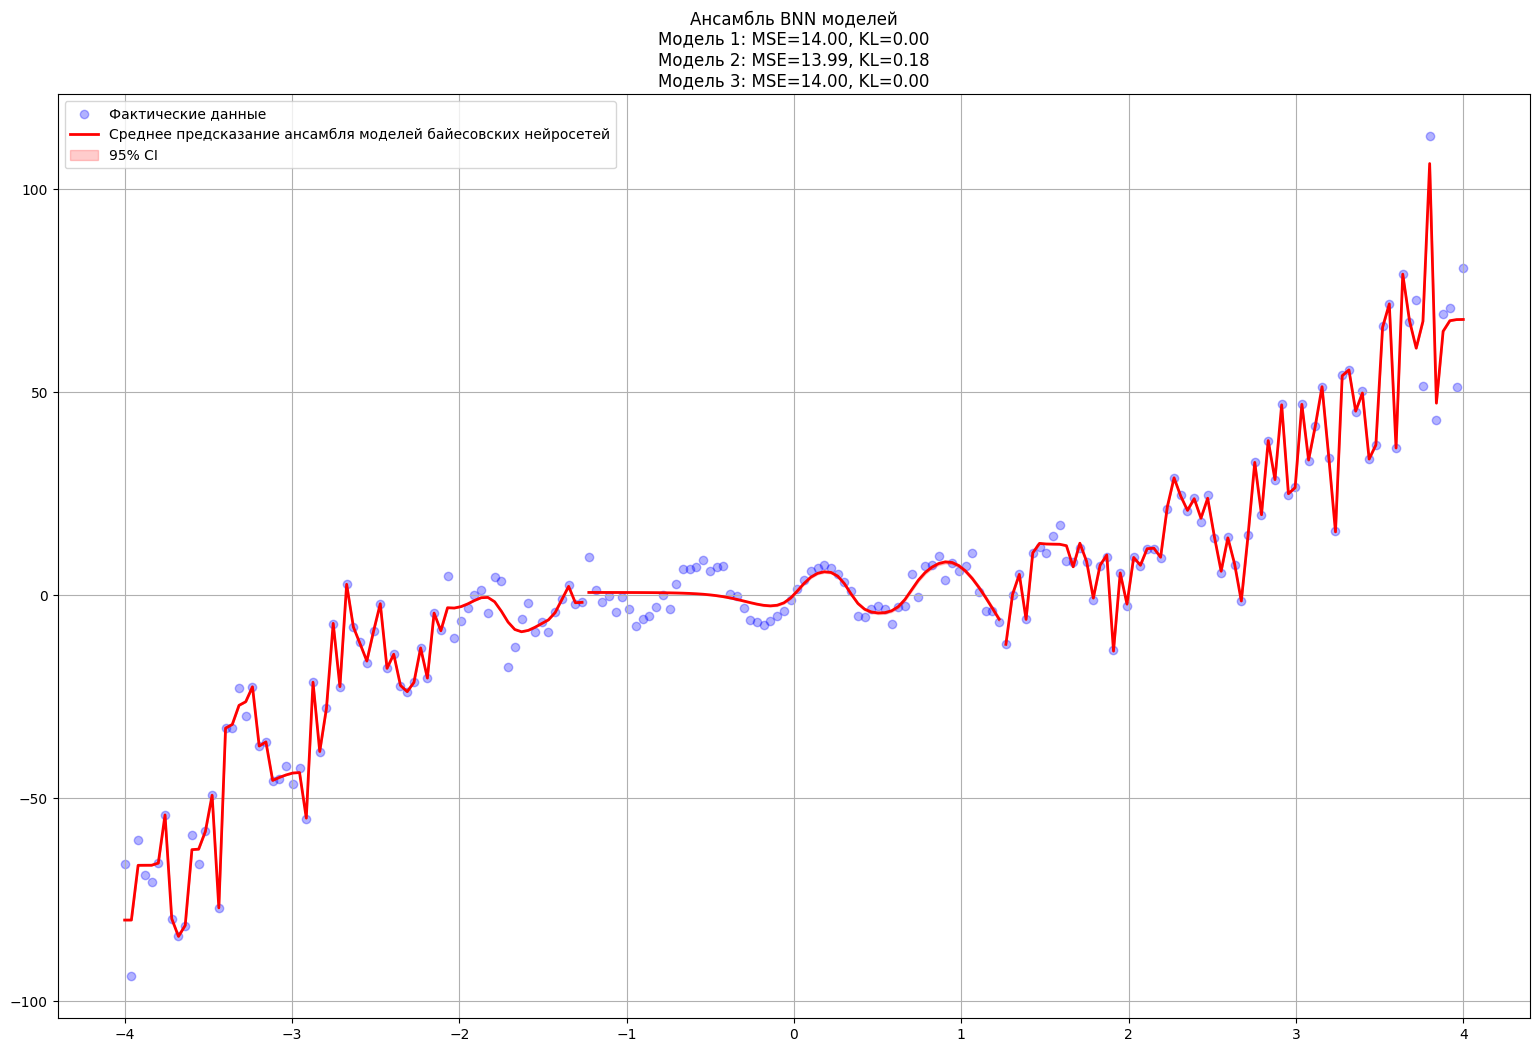

In [33]:
model1.eval()
model2.eval()
model3.eval()
    
with torch.no_grad():
    samples1 = [model1(X_1).numpy() for _ in range(100)]
    samples2 = [model2(X_2).numpy() for _ in range(100)]
    samples3 = [model3(X_3).numpy() for _ in range(100)]
        
    y_mean1 = np.mean(samples1, axis=0)
    y_mean2 = np.mean(samples2, axis=0)
    y_mean3 = np.mean(samples3, axis=0)
    
    y_std1 = np.std(samples1, axis=0)
    y_std2 = np.std(samples2, axis=0)
    y_std3 = np.std(samples3, axis=0)

plt.figure(figsize=(19, 12))
plt.scatter(X_1.numpy(), y_1.numpy(), alpha=0.3, label='Фактические данные', color='blue')
plt.plot(X_1.numpy(), y_mean1, 'r', lw=2, label='Среднее предсказание ансамбля моделей байесовских нейросетей')
plt.fill_between(X_1.numpy().ravel(), 
                y_mean1.ravel() - 2*y_std1.ravel(),
                y_mean1.ravel() + 2*y_std1.ravel(),
                alpha=0.2, color='r')
plt.scatter(X_2.numpy(), y_2.numpy(), alpha=0.3, color='blue')
plt.plot(X_2.numpy(), y_mean2, 'r', lw=2)
plt.fill_between(X_2.numpy().ravel(), 
                y_mean2.ravel() - 2*y_std2.ravel(),
                y_mean2.ravel() + 2*y_std2.ravel(),
                alpha=0.2, color='r')
plt.scatter(X_3.numpy(), y_3.numpy(), alpha=0.3, color='blue')
plt.plot(X_3.numpy(), y_mean3, 'r', lw=2)
plt.fill_between(X_3.numpy().ravel(), 
                y_mean3.ravel() - 2*y_std3.ravel(),
                y_mean3.ravel() + 2*y_std3.ravel(),
                alpha=0.2, color='r', label='95% CI')
plt.legend()
plt.title(f'Ансамбль BNN моделей\n'
          f'Модель 1: MSE={mse1:.2f}, KL={kl1:.2f}\n'
          f'Модель 2: MSE={mse2:.2f}, KL={kl2:.2f}\n'
          f'Модель 3: MSE={mse3:.2f}, KL={kl3:.2f}')
plt.grid(True)
plt.show()

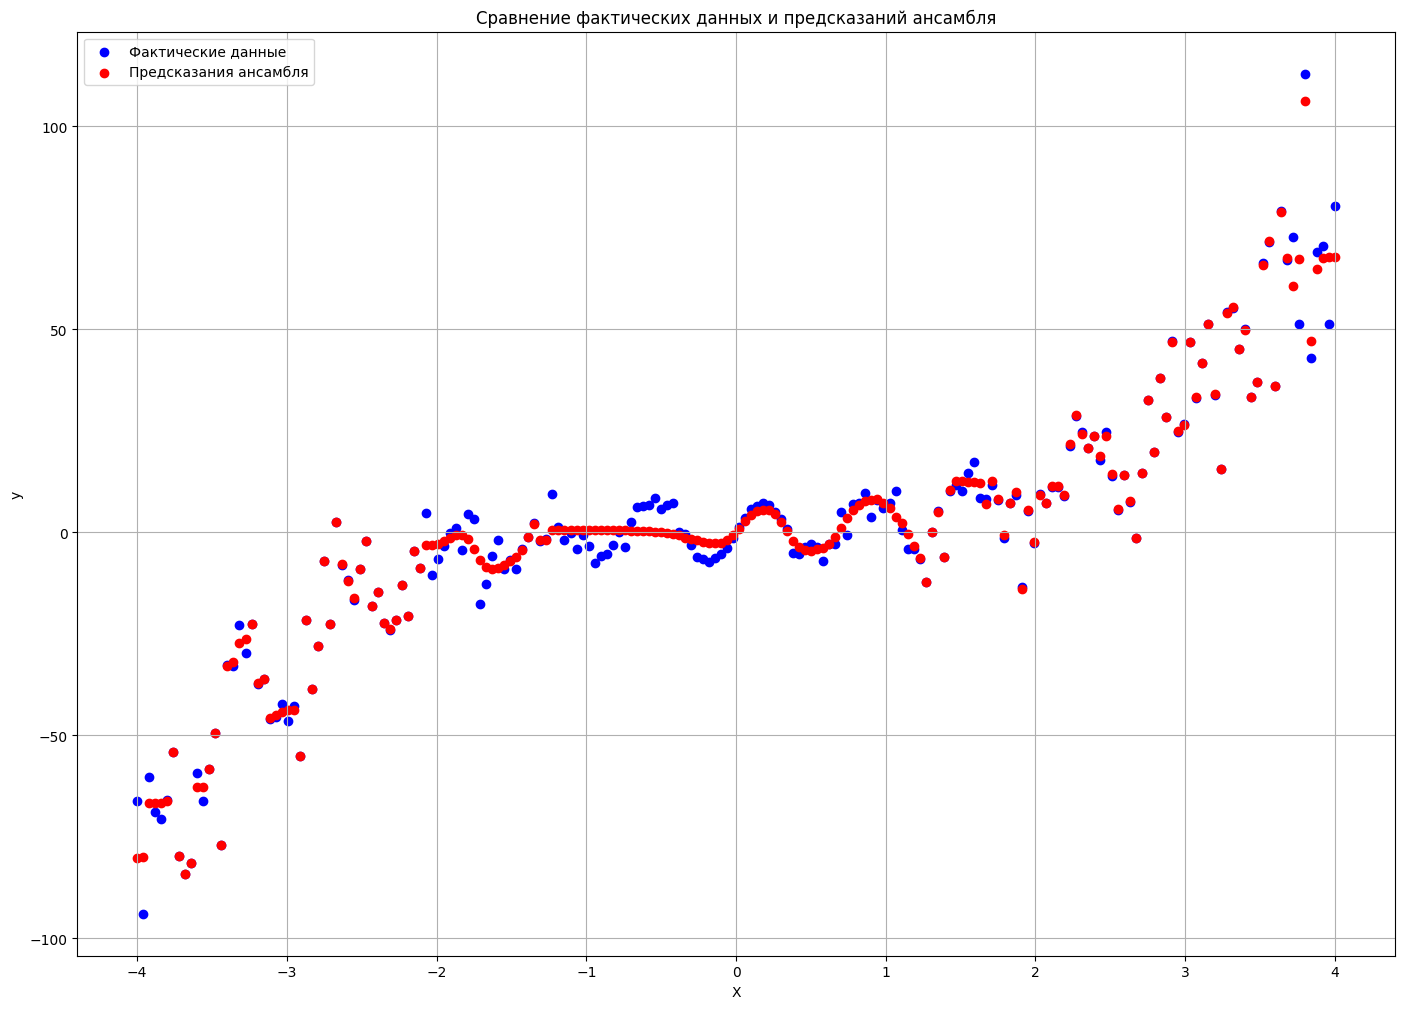

In [34]:
X_pred = torch.linspace(-4, 4, 200).unsqueeze(1)  # 200 точек от -4 до 4
models = [model1, model2, model3]  # Создаем экземпляры моделей

def ensemble_predict(models, X):
    predictions = []
    for x in X: 
        x_val = x.item()  
        with torch.no_grad():
            if x_val < -1.25:
                pred = models[0](x.unsqueeze(0)).numpy()
            elif x_val > 1.25:
                pred = models[2](x.unsqueeze(0)).numpy()
            else:
                pred = models[1](x.unsqueeze(0)).numpy()
            predictions.append(pred)
    return np.concatenate(predictions) 

y_pred = ensemble_predict(models, X_pred)

plt.figure(figsize=(17, 12))
plt.scatter(X_1.numpy(), y_1.numpy(), color='blue', label='Фактические данные')
plt.scatter(X_2.numpy(), y_2.numpy(), color='blue')
plt.scatter(X_3.numpy(), y_3.numpy(), color='blue')
plt.scatter(X_pred.numpy(), y_pred, color='red', label='Предсказания ансамбля')
plt.title('Сравнение фактических данных и предсказаний ансамбля')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid()